In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from os import listdir
sns.set(style="ticks", font_scale=1.2)

from utils import *

OUTPUT measures (4): ['output_entropy', 'output_rank_correct', 'output_logprob_correct', 'output_logprobdiff']
PROCESS measures (15): ['auc_entropy', 'layer_biggest_change_entropy', 'auc_rank_correct', 'layer_biggest_change_rank_correct', 'auc_logprob_correct', 'layer_biggest_change_logprob_correct', 'auc_logprobdiff_pos', 'auc_logprobdiff_neg', 'layer_biggest_change_logprobdiff', 'auc_boosting_pos', 'auc_boosting_neg', 'layer_argmax_boosting', 'twostage_magnitude', 'twostage_magnitude_latter34', 'twostage_layer']


# Read R2 data

In [2]:
def read_model_human_data(lens="logit_lens"):
    folder = f"../../data/human_model_combined/{lens}"
    files = sorted(listdir(folder))
    dfs = []
    for f in files:
        df = pd.read_csv(f"{folder}/{f}")
        splits = f.split("_")
        task = splits[0]
        if task == "animals":
            df = df.rename(columns={"Typicality": "condition"})
        df["task"] = task
        if task == "vision":
            dataset = splits[1]
            df["dataset"] = dataset
            model = "_".join(splits[2:]).replace(".csv", "")
        else:
            model = splits[-1].replace(".csv", "")
            if task == "capitals-recall":
                df["response_correct_gpt4"] = (df["gpt-4o_label"] == "Correct")
        df["model"] = model
        df["model_family"] = get_model_family(model)
        df["model_size"] = get_model_size(model)
        df["log_model_size"] = np.log(df["model_size"])
        dfs.append(df)
    df = pd.concat(dfs)
    return df

def _get_corr_summary(df, task, grouping, ivs, dv_groups, filter_correct=True):
    data = []
    # Compute model means for each IV.
    models = df.model.unique()
    missing_models = [m for m in (MODELS if task!="vision" else VISION_MODELS) if m not in models]
    if len(missing_models) >= 1:
        print("  *** Missing model data:", missing_models)
    else:
        print("  *** OK model data!")
    print("="*80)
    all_model_means = df.groupby(grouping+["model"])[ivs].mean().reset_index().set_index(grouping)
    # Iterate over each DV group (accuracy, RT, processing).
    for dv_group, dvs in dv_groups:
        # Get human DV means.
        dvs = [dv for dv in dvs if dv in TASK_DVS[task]]
        if dv_group != "Accuracy" and filter_correct:
            print(f"Only analyzing CORRECT trials for these DVs: {dvs}")
            correct_var = "response_correct" if task != "capitals-recall" else "response_correct_gpt4"
            human_means = df[df[correct_var].astype(bool)].groupby(grouping)[dvs].mean()
        else:
            print(f"Analyzing ALL trials for these DVs: {dvs}")
            human_means = df.groupby(grouping)[dvs].mean()
        # Iterate through models, IVs, and DVs.
        for model in models:
            model_means = all_model_means[all_model_means.model==model]
            for iv in ivs:
                if model_means[iv].nunique() == 1:
                    print("SKIPPING IV (constant input):", task, model, iv)
                    continue
                for dv in dvs:
                    if task == "vision":
                        if any(s in iv for s in ["logprobdiff", "boosting", "twostage"]):
                            continue
                    item_means = human_means.join(
                        model_means[iv], 
                        on=grouping
                    ).dropna(subset=[dv, iv])
                    if len(item_means) < 2:
                        print("SKIPPING IV/DV COMBO (too many NaNs):", task, model, dv, iv)
                        continue
                    slope, intercept, r_value, p_value, std_err = stats.linregress(
                        item_means[iv], 
                        y=item_means[dv]
                    )
                    data.append(dict(
                        iv=iv,
                        dv=dv,
                        model=model,
                        model_family=get_model_family(model),
                        model_size=get_model_size(model),
                        task=task,
                        dv_group=dv_group,
                        iv_group=get_metric_group(iv),
                        is_baseline=(iv.startswith("output")),
                        r=r_value,
                        r2=r_value**2
                    ))
    return pd.DataFrame(data)
    
def get_corr_summary(df, filter_correct=True):    
    groupings = {
        "capitals-recall": ["entity"],
        "capitals-recognition": ["entity"],
        "animals": ["exemplar_de"],
        "syllogism": ["unique_id"],
        "vision": ["item_id"]
    }
        
    # Define groups of DVs.
    dv_groups = get_dv_groups()
    
    # Define IVs.
    ivs = PROCESS_IVS
    
    # Compute R2 values.
    all_results = []
    for task in df.task.unique():
        grouping = groupings[task]
        print("="*80)
        print(task)
        if task == "vision":
            for dataset in df[df.task=="vision"].dataset.unique():
                data = df[(df.task==task)&(df.dataset==dataset)]
                res = _get_corr_summary(data, task, grouping, ivs, dv_groups, filter_correct=filter_correct)
                res["dataset"] = dataset
                all_results.append(res)
        else:
            data = df[df.task==task]
            res = _get_corr_summary(data, task, grouping, ivs, dv_groups, filter_correct=filter_correct)
            all_results.append(res)
    corrs = pd.concat(all_results)
    corrs["log_model_size"] = np.log(corrs["model_size"])

    return corrs

# Compute R2 data for all domains.
r2_df = get_corr_summary(
    read_model_human_data(lens="logit_lens"), 
    filter_correct=True
)
r2_df.head()

animals
  *** OK model data!
Analyzing ALL trials for these DVs: ['response_correct']
SKIPPING IV (constant input): animals gemma-2-2b layer_biggest_change_logprob_correct
Only analyzing CORRECT trials for these DVs: ['RT']
SKIPPING IV (constant input): animals gemma-2-2b layer_biggest_change_logprob_correct
Only analyzing CORRECT trials for these DVs: ['MAD', 'AUC', 'xpos_flips', 'acc_max_time']
SKIPPING IV (constant input): animals gemma-2-2b layer_biggest_change_logprob_correct
capitals-recall
  *** OK model data!
Analyzing ALL trials for these DVs: ['response_correct_strict', 'response_correct_gpt4']
SKIPPING IV (constant input): capitals-recall gemma-2-2b layer_biggest_change_logprob_correct
SKIPPING IV (constant input): capitals-recall gemma-2-9b layer_biggest_change_logprob_correct
SKIPPING IV (constant input): capitals-recall gpt2 auc_boosting_neg
Only analyzing CORRECT trials for these DVs: ['rt']
SKIPPING IV (constant input): capitals-recall gemma-2-2b layer_biggest_change_lo

Only analyzing CORRECT trials for these DVs: ['rt']
Only analyzing CORRECT trials for these DVs: []
  *** OK model data!
Analyzing ALL trials for these DVs: ['response_correct']
Only analyzing CORRECT trials for these DVs: ['rt']
Only analyzing CORRECT trials for these DVs: []
  *** OK model data!
Analyzing ALL trials for these DVs: ['response_correct']
Only analyzing CORRECT trials for these DVs: ['rt']
Only analyzing CORRECT trials for these DVs: []
  *** OK model data!
Analyzing ALL trials for these DVs: ['response_correct']
Only analyzing CORRECT trials for these DVs: ['rt']
Only analyzing CORRECT trials for these DVs: []
  *** OK model data!
Analyzing ALL trials for these DVs: ['response_correct']
Only analyzing CORRECT trials for these DVs: ['rt']
Only analyzing CORRECT trials for these DVs: []


,iv,dv,model,model_family,model_size,task,dv_group,iv_group,is_baseline,r,r2,dataset,log_model_size
0,auc_entropy,response_correct,Falcon3-10B-Base,Falcon-3,10.0,animals,Accuracy,Uncertainty,False,-0.594625,0.353579,NaN,2.302585
1,layer_biggest_change_entropy,response_correct,Falcon3-10B-Base,Falcon-3,10.0,animals,Accuracy,Uncertainty,False,-0.284195,0.080767,NaN,2.302585
2,auc_rank_correct,response_correct,Falcon3-10B-Base,Falcon-3,10.0,animals,Accuracy,Confidence,False,-0.219396,0.048135,NaN,2.302585
3,layer_biggest_change_rank_correct,response_correct,Falcon3-10B-Base,Falcon-3,10.0,animals,Accuracy,Confidence,False,0.079795,0.006367,NaN,2.302585
4,auc_logprob_correct,response_correct,Falcon3-10B-Base,Falcon-3,10.0,animals,Accuracy,Confidence,False,-0.010432,0.000109,NaN,2.302585


# Read Bayes Factor data

In [3]:
# Read ALL results (across all datasets and DVs) to perform false discovery correction.
def read_bf_results_single_task(task, result_dir="../r_outputs"):
    files = [f for f in listdir(result_dir) if f.startswith("bf") and task in f]
    dfs = []
    for f in files:
        df = pd.read_csv(f"{result_dir}/{f}")
        if len(df) == 0:
            print(f"Empty data: {f}")
            continue
            
        # Only keep rows with critical fit.
        df = df[(df.term=="critical_fit")]
        
        # Add other relevant metadata.
        df["model_family"] = df.model.apply(get_model_family)
        df["model_size"] = df.model.apply(get_model_size)
        df["log_model_size"] = np.log(df.model_size)
        df["iv_group"] = df.iv.apply(get_metric_group)
        df["is_control"] = df.iv.apply(lambda x: x.startswith("control"))
        df["metric_quantity_type"] = df.iv.apply(get_quantity_type)
        df["dv_group"] = df.dv.map(DV_TYPES)
        dfs.append(df)
        
    if len(dfs) > 0:
        df = pd.concat(dfs)
        df["task"] = task
        return df
    else:
        return

def read_bf_results(result_dir="../r_outputs", filter_correct=True):
    df = pd.concat([
        read_bf_results_single_task(task=task, result_dir=result_dir) 
        for task in ["capitals-recall", "capitals-recognition", "animals", "syllogism", "vision"]
    ]).rename(columns={"file_suffix": "dataset"})
    
    # Perform exclusions.
    metrics_to_exclude = ["twostage_magnitude_latter34"]
    print("Excluding the following metrics:", metrics_to_exclude)
    df = df[~df.iv.isin(metrics_to_exclude)]
    if filter_correct:
        df = df[
            ((df.dv.str.contains("response_correct")) & (df.data_subset=="all_trials")) | \
            (df.data_subset=="filteredCorrect")
        ]
    
    print("Total number of rows:", len(df))
    print(df.groupby("dv")["data_subset"].value_counts(normalize=True))
    return df
    
bf_df = read_bf_results()
bf_df.head()

Excluding the following metrics: ['twostage_magnitude_latter34']
Total number of rows: 8722
dv                                  data_subset    
AUC                                 filteredCorrect    1.0
MAD                                 filteredCorrect    1.0
RT                                  filteredCorrect    1.0
acc_max_time                        filteredCorrect    1.0
n_backspace                         filteredCorrect    1.0
n_keystrokes_len_norm               filteredCorrect    1.0
response_correct                    all_trials         1.0
response_correct_gpt4               all_trials         1.0
response_correct_strict             all_trials         1.0
rt                                  filteredCorrect    1.0
time_stroke_after_last_empty_trial  filteredCorrect    1.0
xpos_flips                          filteredCorrect    1.0
Name: data_subset, dtype: float64


,term,formula,log_BF,iv,baseline_type,dv,data_subset,model,dataset,model_family,model_size,log_model_size,iv_group,is_control,metric_quantity_type,dv_group,task
1,critical_fit,auc_entropy + output_entropy * output_rank_cor...,-2.077185,auc_entropy,baseline_final,rt,filteredCorrect,gpt2-xl,NaN,GPT-2,1.5,0.405465,Uncertainty,False,AUC,RT,capitals-recall
3,critical_fit,auc_entropy + midpoint_entropy * midpoint_rank...,-2.597492,auc_entropy,baseline_midpoint,rt,filteredCorrect,gpt2-xl,NaN,GPT-2,1.5,0.405465,Uncertainty,False,AUC,RT,capitals-recall
4,critical_fit,layer_biggest_change_entropy + output_entropy ...,-2.990379,layer_biggest_change_entropy,baseline_final,rt,filteredCorrect,gpt2-xl,NaN,GPT-2,1.5,0.405465,Uncertainty,False,MaxDeltaLayer,RT,capitals-recall
5,critical_fit,layer_biggest_change_entropy + midpoint_entrop...,-3.445469,layer_biggest_change_entropy,baseline_midpoint,rt,filteredCorrect,gpt2-xl,NaN,GPT-2,1.5,0.405465,Uncertainty,False,MaxDeltaLayer,RT,capitals-recall
6,critical_fit,auc_rank_correct + output_entropy * output_ran...,-0.272385,auc_rank_correct,baseline_final,rt,filteredCorrect,gpt2-xl,NaN,GPT-2,1.5,0.405465,Confidence,False,AUC,RT,capitals-recall


# Figure 3a

Only considering baseline_final
ONLY ANALYZING TEXT DATA
Saving figure to ../../figures/r2_bf_all_metrics_text_baseline_final.pdf


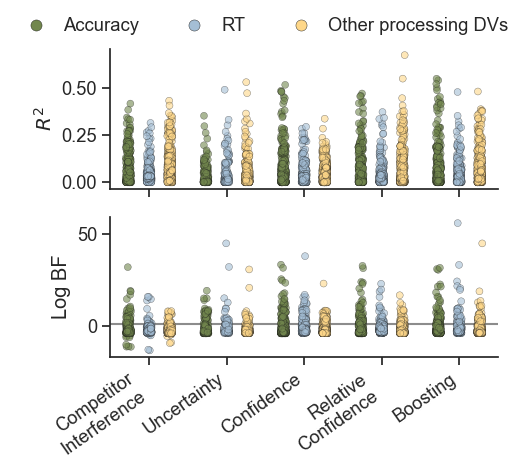

In [4]:
def plot_r2_bf(r2_df, bf_df, baseline_type="baseline_final", vision=False, render=False):
    print(f"Only considering {baseline_type}")
    bf_df = bf_df[bf_df.baseline_type==baseline_type]

    if vision:
        print("ONLY ANALYZING VISION DATA")
        r2_df = r2_df[r2_df.task=="vision"]
        bf_df = bf_df[bf_df.task=="vision"]
        
        order = ["Uncertainty", "Confidence"]
        labels = order
        figsize = (3,4)
    else:
        print("ONLY ANALYZING TEXT DATA")
        r2_df = r2_df[r2_df.task!="vision"]
        bf_df = bf_df[bf_df.task!="vision"]
        
        order = [
            "Two-Stage", 
            "Uncertainty", 
            "Confidence", 
            "Relative confidence", 
            "Boosting"
        ]
        labels = [
            "Competitor\nInterference",
            "Uncertainty",
            "Confidence",
            "Relative\nConfidence",
            "Boosting"
        ]
        figsize = (5,4)
        
    # Define groups of DVs.
    dv_groups = [dv_group[0] for dv_group in get_dv_groups()]
    dv_groups = [dv_group for dv_group in dv_groups if dv_group in r2_df.dv_group.unique()]
    
    kws = dict(
        x="iv_group",
        order=order,
        hue="dv_group",
        hue_order=dv_groups,
        palette=DV_GROUP_PAL,
        dodge=True,
        edgecolor="k",
        linewidth=0.3,
        alpha=0.6,
        size=5
    )
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize, sharex=True)
    for i, ax in enumerate(axes):
        # FIRST ROW: R2
        if i == 0:
            ax = sns.stripplot(
                data=r2_df,
                y="r2",
                ax=ax,
                **kws
            )
            ax.set_xlabel("")
            ax.set_ylabel("$R^2$")
            ax.get_legend().remove()
        # SECOND ROW: BAYES FACTOR
        else:
            ax = sns.stripplot(
                data=bf_df,
                y="log_BF",
                ax=ax,
                **kws
            )
            ax.set_ylabel("Log BF")
            ax.axhline(np.log(3), color="k", alpha=0.5)
            ax.set_xlabel("")
            ax.set_xticks(
                range(len(labels)), 
                labels,
                rotation=35,
                ha="right"
            )
            ax.get_legend().remove()
            
    handles, labels = ax.get_legend_handles_labels()
    for h in handles:
        h.set(alpha=1, markersize=8)
    plt.figlegend(
        handles,
        labels,
        ncols=3,
        loc="upper center",
        bbox_to_anchor=(0.43, 1),
        handletextpad=0.5,
        frameon=False
    )
    sns.despine()
    if render:
        if vision:
            modality = "vision"
        else:
            modality = "text"
        outpath = f"../../figures/r2_bf_all_metrics_{modality}_{baseline_type}.pdf"
        print(f"Saving figure to {outpath}")
        plt.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    
plot_r2_bf(
    r2_df[(~r2_df.is_baseline)],
    bf_df,
    baseline_type="baseline_final",
    vision=False,
    render=True
)

# Figure 3b

/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_35353/765505638.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["model_size_bucket"] = buckets


(0.123, 1.5] ---> (0.123, 1.5]
(1.5, 7.0] ---> (1.5, 7]
(7.0, 10.0] ---> (7, 10]
(10.0, 32.0] ---> (10, 32]
(32.0, 405.0] ---> (32, 405]
(0.123, 1.5] ---> (0.123, 1.5]
(1.5, 7] ---> (1.5, 7]
(7, 10] ---> (7, 10]
(10, 32] ---> (10, 32]
(32, 405] ---> (32, 405]


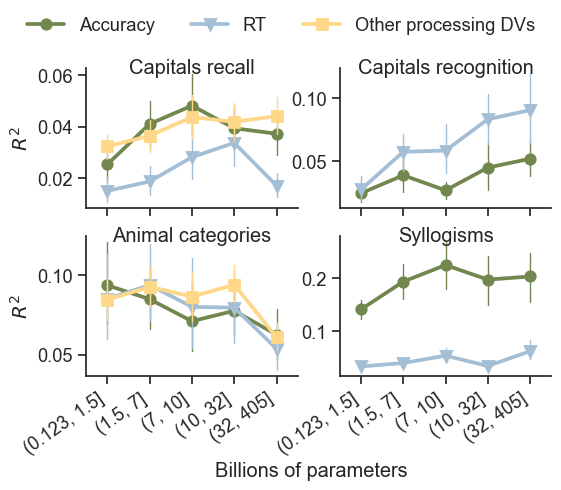

In [5]:
def get_bucket_label(b):
    lo, hi = b.split(", ")
    lo = float(lo.lstrip("("))
    hi = float(hi.rstrip("]"))
    if str(lo).endswith(".0"):
        lo_str = str(int(lo))
    else:
        lo_str = str(lo)
    if str(hi).endswith(".0"):
        hi_str = str(int(hi))
    else:
        hi_str = str(hi)
    return f"({lo_str}, {hi_str}]"
        
def plot_r2_by_size_bucket(data, n_buckets=4, render=False, min_r2_threshold=None):
    # Add model size "bucket".
    buckets = pd.qcut(data["model_size"], n_buckets)
    data["model_size_bucket"] = buckets 
    order = sorted(data["model_size_bucket"].unique())
    
    # Define groups of DVs.
    dv_groups = get_dv_groups()
    
    if min_r2_threshold is not None:
        print("Only keeping R2 values above", min_r2_threshold)
        data = data[data.r2 > min_r2_threshold]
    
    tasks = [t for t in TASKS if t in data.task.unique()]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,4), sharex=True, sharey=False)
    for i, ax in enumerate(axes.flatten()):
        task = tasks[i]
        ax = sns.pointplot(
            data=data[data.task==task],
            x="model_size_bucket",
            order=order,
            y="r2",
            ax=ax,
            hue="dv_group",
            palette=DV_GROUP_PAL,
            markers=["o", "v", "s"],
            err_kws=dict(lw=1),
            alpha=1
        )
        
        if i in [0,2]:
            ax.set_ylabel("$R^2$")
        else:
            ax.set_ylabel("")
            
        ax.set_title(TASK_NAMES[task], y=0.9)

        if i in [2, 3]:
            labs = ax.get_xticklabels()
            pretty_labs = [get_bucket_label(lab.get_text()) for lab in labs]
            for lab, pretty_lab in zip(labs, pretty_labs):
                print(lab.get_text() + " ---> " + pretty_lab)
            ax.set_xticks(
                range(len(labs)),
                pretty_labs,
                rotation=35,
                ha="right",
            )
        ax.set_xlabel("")
        ax.get_legend().remove()

    fig.supxlabel("Billions of parameters", y=-0.15, size="medium")
    handles, labels = axes[0][0].get_legend_handles_labels()
    plt.figlegend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.45, 1.05), frameon=False)
    sns.despine()
    if render:
        fname = "r2_size_text"
        if min_r2_threshold is not None:
            fname += f"_threshold{min_r2_threshold}"
        plt.savefig(f"../../figures/{fname}.pdf", dpi=300, bbox_inches="tight")
    plt.show()
    

plot_r2_by_size_bucket(
    r2_df[(~r2_df.is_baseline)&(r2_df.task != "vision")],
    n_buckets=5, 
    render=True,
    min_r2_threshold=None
)

# Appendix

Only considering baseline_midpoint
ONLY ANALYZING TEXT DATA
Saving figure to ../../figures/r2_bf_all_metrics_text_baseline_midpoint.pdf


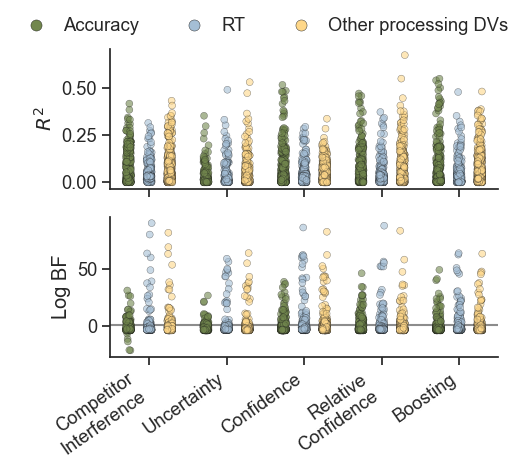

In [6]:
# Midpoint-layer baseline
plot_r2_bf(
    r2_df[(~r2_df.is_baseline)],
    bf_df,
    baseline_type="baseline_midpoint",
    vision=False,
    render=True
)

Only considering baseline_final
ONLY ANALYZING VISION DATA
Saving figure to ../../figures/r2_bf_all_metrics_vision_baseline_final.pdf


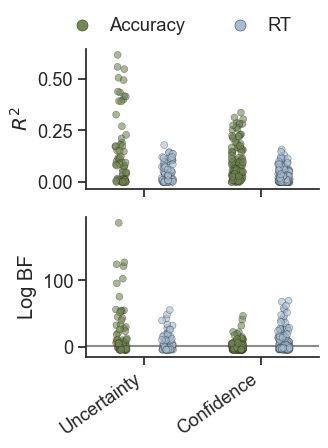

Only considering baseline_midpoint
ONLY ANALYZING VISION DATA
Saving figure to ../../figures/r2_bf_all_metrics_vision_baseline_midpoint.pdf


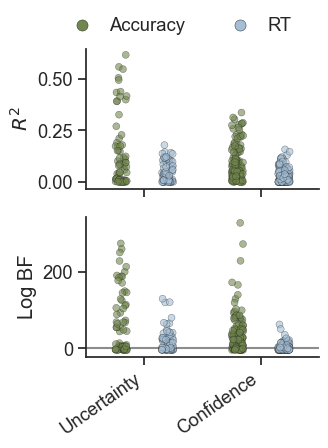

In [7]:
# Vision
for baseline_type in ["baseline_final", "baseline_midpoint"]:
    plot_r2_bf(
        r2_df[(~r2_df.is_baseline)],
        bf_df,
        vision=True,
        baseline_type=baseline_type,
        render=True
    )

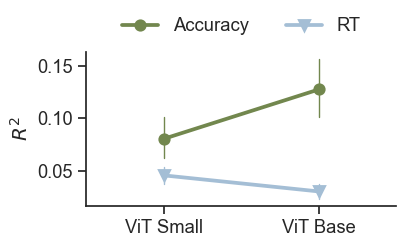

In [8]:
def plot_r2_by_size_vision(data, render=False, min_r2_threshold=None):
    order = VISION_MODELS
    
    # Define groups of DVs.
    dv_groups = get_dv_groups()[:2]
    
    if min_r2_threshold is not None:
        print("Only keeping R2 values above", min_r2_threshold)
        data = data[data.r2 > min_r2_threshold]
    
    ax = sns.pointplot(
        data=data,
        hue="dv_group",
        x="model",
        order=order,
        y="r2",
        palette=DV_GROUP_PAL,
        err_kws=dict(lw=1),
        markers=["o", "v"],
        alpha=1
    )
    ax.set_ylabel("$R^2$")
    ax.set_xticks(
        range(len(order)),
        [MODEL_MAP[m] for m in order], 
#         rotation=45, ha="right", size="small"
    )
    ax.set_xlabel("")
    ax.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, 1), frameon=False)
    plt.gcf().set_size_inches(4,2)
    plt.subplots_adjust(wspace=0.2)
    sns.despine()
    if render:
        if min_r2_threshold is not None:
            plt.savefig(f"../../figures/r2_size_vision_threshold{min_r2_threshold}.pdf", dpi=300, bbox_inches="tight")
        else:
            plt.savefig("../../figures/r2_size_vision.pdf", dpi=300, bbox_inches="tight")
    plt.show()
    
plot_r2_by_size_vision(
    r2_df[(~r2_df.is_baseline)&(r2_df.task == "vision")], 
    render=True,
    min_r2_threshold=None
)

### Logit lens vs tuned lens

In [9]:
r2_tl = get_corr_summary(read_model_human_data(lens="tuned_lens"), filter_correct=True)
r2_tl.head()

animals
  *** Missing model data: ['gpt2-medium', 'Llama-2-70b-hf', 'Llama-3.1-8B', 'Llama-3.1-70B', 'Llama-3.1-405B', 'gemma-2-2b', 'gemma-2-9b', 'gemma-2-27b', 'OLMo-2-1124-7B', 'OLMo-2-1124-13B', 'OLMo-2-0325-32B', 'Falcon3-1B-Base', 'Falcon3-3B-Base', 'Falcon3-10B-Base']
Analyzing ALL trials for these DVs: ['response_correct']
SKIPPING IV (constant input): animals gpt2-xl layer_biggest_change_entropy
Only analyzing CORRECT trials for these DVs: ['RT']
SKIPPING IV (constant input): animals gpt2-xl layer_biggest_change_entropy
Only analyzing CORRECT trials for these DVs: ['MAD', 'AUC', 'xpos_flips', 'acc_max_time']
SKIPPING IV (constant input): animals gpt2-xl layer_biggest_change_entropy
capitals-recall
  *** Missing model data: ['gpt2-medium', 'Llama-2-70b-hf', 'Llama-3.1-8B', 'Llama-3.1-70B', 'Llama-3.1-405B', 'gemma-2-2b', 'gemma-2-9b', 'gemma-2-27b', 'OLMo-2-1124-7B', 'OLMo-2-1124-13B', 'OLMo-2-0325-32B', 'Falcon3-1B-Base', 'Falcon3-3B-Base', 'Falcon3-10B-Base']
Analyzing ALL tr

,iv,dv,model,model_family,model_size,task,dv_group,iv_group,is_baseline,r,r2,log_model_size
0,auc_entropy,response_correct,Llama-2-13b-hf,Llama-2,13.0,animals,Accuracy,Uncertainty,False,0.029706,0.000882,2.564949
1,layer_biggest_change_entropy,response_correct,Llama-2-13b-hf,Llama-2,13.0,animals,Accuracy,Uncertainty,False,0.069374,0.004813,2.564949
2,auc_rank_correct,response_correct,Llama-2-13b-hf,Llama-2,13.0,animals,Accuracy,Confidence,False,0.292549,0.085585,2.564949
3,layer_biggest_change_rank_correct,response_correct,Llama-2-13b-hf,Llama-2,13.0,animals,Accuracy,Confidence,False,-0.272148,0.074065,2.564949
4,auc_logprob_correct,response_correct,Llama-2-13b-hf,Llama-2,13.0,animals,Accuracy,Confidence,False,-0.223721,0.050051,2.564949


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_35353/3299071539.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ll["lens"] = "logit_lens"


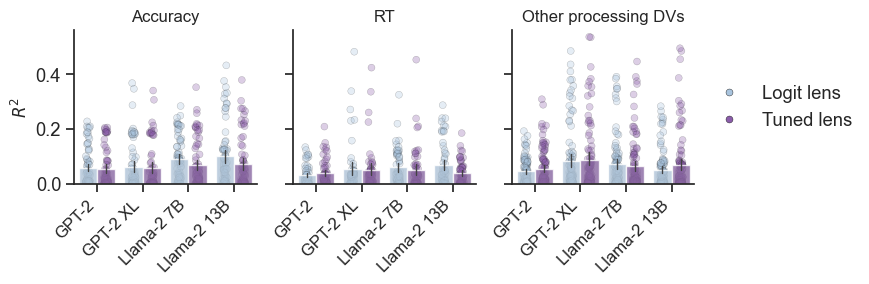

<Figure size 640x480 with 0 Axes>

In [10]:
def compare_r2_by_lens(ll, tl, render=False):
    # Define groups of DVs.
    dv_groups = get_dv_groups()
    
    ll = ll[ll.model.isin(tl.model.unique())]
    ll["lens"] = "logit_lens"
    tl["lens"] = "tuned_lens"
    data = pd.concat([ll, tl]).reset_index()
    
    models = [m for m in MODELS if m in data.model.unique()]
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8, 2))
    for i, ax in enumerate(axes):
        dv_group = dv_groups[i][0]
        ax = sns.stripplot(
            data=data[data.dv_group==dv_group],
            x="model",
            hue="lens",
            hue_order=["logit_lens", "tuned_lens"],
            order=models,
            y="r2",
            ax=ax,
            palette="BuPu",
            dodge=True,
            edgecolor="k",
            linewidth=0.3,
            alpha=0.3,
            zorder=-2
        )
        ax = sns.barplot(
            data=data[data.dv_group==dv_group],
            x="model",
            hue="lens",
            hue_order=["logit_lens", "tuned_lens"],
            order=models,
            y="r2",
            ax=ax,
            err_kws=dict(lw=1),
            palette="BuPu",
            alpha=0.8
        )

        if i == 2:
            handles, _ = ax.get_legend_handles_labels()
            for h in handles:
                h.set(alpha=1)
            labels = ["Logit lens", "Tuned lens"]
            ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1,0.5), frameon=False)
        else:
            ax.get_legend().remove()
        ax.set_ylabel("$R^2$", size="small")
        ax.set_title(dv_group, size="small")
        ax.set_xlabel("")
        ax.set_xticks(
            range(len(models)),
            [MODEL_MAP[m] for m in models], 
            rotation=45, ha="right", size="small"
        )

    sns.despine()
    if render:
        plt.savefig("../../figures/r2_text_lens_comparison.pdf", dpi=300, bbox_inches="tight")
    plt.show()
    plt.clf()
    
compare_r2_by_lens(r2_df, r2_tl, render=True)